# 掛載雲端硬碟

In [1]:
# import os
# from google.colab import drive

# drive.mount('/content/drive')

# os.chdir('/content/drive/MyDrive/Colab Notebooks/AI_CUP_DemoCode/TrainingData/')

# 載入套件

In [2]:
import numpy as np
import pandas as pd
import librosa

import tensorflow as tf
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

# 模型架構

In [3]:
# default hyperparameters
NEURONS = 300
HIDDEN_LAYERS = 3

def create_DNN(input_shape, neurons = NEURONS, hidden_layers = HIDDEN_LAYERS, learning_rate = 0.001, verbose=0):
    model = Sequential()

    model.add(Dense(neurons, input_dim=input_shape))
    model.add(Activation('relu'))

    for i in range(hidden_layers-1):
        model.add(Dense(neurons))
        model.add(Activation('relu'))
#         model.add(Dropout(0.2))


    model.add(Dense(5))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) # categorical_crossentropy

    if verbose:
        model.summary()
    
    return model

# 載入訓練資料

In [4]:
# 讀取訓練資料集表單
source_df = pd.read_csv('./Training_Dataset/training_datalist.csv')

print("source_df.shape :", source_df.shape)
print("source_df.columns :", source_df.columns)

source_df.shape : (1000, 28)
source_df.columns : Index(['ID', 'Sex', 'Age', 'Disease category', 'Narrow pitch range',
       'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
       'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
       'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
       'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
       'Head and Neck Cancer', 'Head injury', 'CVA',
       'Voice handicap index - 10'],
      dtype='object')


# 資料前處理

In [5]:
def medical_data_proccessing(df):
    # 這邊要加入ID  用於轉換資料時對應
    medical_col = ['ID', 'Sex', 'Age', 'Narrow pitch range',
                'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
                'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
                'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
                'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
                'Head and Neck Cancer', 'Head injury', 'CVA',
                'Voice handicap index - 10', 'Disease category']
    
    df = df.loc[df['Disease category'].isin([1, 2, 3, 4, 5]), medical_col]

    # 將性別編碼0,1
    df['Sex'] = df['Sex'] - 1

    # 將空值填0
    df['PPD'] = df['PPD'].fillna(0)
    df['Voice handicap index - 10'] = df['Voice handicap index - 10'].fillna(0)

    # 正規化過大的數值
    df['Age'] = df['Age'] / 50
    df['Voice handicap index - 10'] = df['Voice handicap index - 10'] / 40

    return df

# 切分訓練與驗證資料

In [6]:
training_df, test_df = train_test_split(source_df, test_size=0.2, random_state=333)

print("training_df shape :", training_df.shape, ", test_df shape :", test_df.shape)

training_df shape : (800, 28) , test_df shape : (200, 28)


In [7]:
training_df = medical_data_proccessing(training_df)

# 在dataframe中加入要訓練的音檔路徑
training_df['wav_path'] = training_df['ID'].map("./Training_Dataset/training_voice_data/{}.wav".format)

print("Disease category in training_df :", training_df['Disease category'].unique())
print("training_df col :\n", training_df.columns)
print("training_df shape :", training_df.shape)

Disease category in training_df : [1 2 5 3 4]
training_df col :
 Index(['ID', 'Sex', 'Age', 'Narrow pitch range', 'Decreased volume', 'Fatigue',
       'Dryness', 'Lumping', 'heartburn', 'Choking', 'Eye dryness', 'PND',
       'Smoking', 'PPD', 'Drinking', 'frequency', 'Diurnal pattern',
       'Onset of dysphonia ', 'Noise at work', 'Occupational vocal demand',
       'Diabetes', 'Hypertension', 'CAD', 'Head and Neck Cancer',
       'Head injury', 'CVA', 'Voice handicap index - 10', 'Disease category',
       'wav_path'],
      dtype='object')
training_df shape : (800, 29)


In [8]:
test_df = medical_data_proccessing(test_df)


# 在dataframe中加入要測試的音檔路徑
test_df['wav_path'] = test_df['ID'].map("./Training_Dataset/training_voice_data/{}.wav".format)

print("test_df columns :", test_df.columns)
print("test_df.shape :", test_df.shape)

test_df columns : Index(['ID', 'Sex', 'Age', 'Narrow pitch range', 'Decreased volume', 'Fatigue',
       'Dryness', 'Lumping', 'heartburn', 'Choking', 'Eye dryness', 'PND',
       'Smoking', 'PPD', 'Drinking', 'frequency', 'Diurnal pattern',
       'Onset of dysphonia ', 'Noise at work', 'Occupational vocal demand',
       'Diabetes', 'Hypertension', 'CAD', 'Head and Neck Cancer',
       'Head injury', 'CVA', 'Voice handicap index - 10', 'Disease category',
       'wav_path'],
      dtype='object')
test_df.shape : (200, 29)


## 取出病理資料

In [9]:
training_data_medical = training_df.iloc[:, :27]

print("training_data col :\n", training_data_medical.columns)
print("training_data shape :", training_data_medical.shape)

training_data col :
 Index(['ID', 'Sex', 'Age', 'Narrow pitch range', 'Decreased volume', 'Fatigue',
       'Dryness', 'Lumping', 'heartburn', 'Choking', 'Eye dryness', 'PND',
       'Smoking', 'PPD', 'Drinking', 'frequency', 'Diurnal pattern',
       'Onset of dysphonia ', 'Noise at work', 'Occupational vocal demand',
       'Diabetes', 'Hypertension', 'CAD', 'Head and Neck Cancer',
       'Head injury', 'CVA', 'Voice handicap index - 10'],
      dtype='object')
training_data shape : (800, 27)


In [10]:
test_data_medical = test_df.iloc[:, :27]

print("Test medical data shape :", test_data_medical.shape)
print("Test medical data columns :", test_data_medical.columns)

Test medical data shape : (200, 27)
Test medical data columns : Index(['ID', 'Sex', 'Age', 'Narrow pitch range', 'Decreased volume', 'Fatigue',
       'Dryness', 'Lumping', 'heartburn', 'Choking', 'Eye dryness', 'PND',
       'Smoking', 'PPD', 'Drinking', 'frequency', 'Diurnal pattern',
       'Onset of dysphonia ', 'Noise at work', 'Occupational vocal demand',
       'Diabetes', 'Hypertension', 'CAD', 'Head and Neck Cancer',
       'Head injury', 'CVA', 'Voice handicap index - 10'],
      dtype='object')


## 聲學音檔轉換MFCC特徵

In [11]:
# define function
def audio_to_mfccs(filename, sample_rate=44100, offset=0, duration=None):
    voice, sample_rate = librosa.load(filename, sr=sample_rate, offset=offset, duration=duration)
    
    n_fft = int(16/1000 * sample_rate)  # Convert 16 ms to samples
    hop_length = int(8/1000 * sample_rate)  # Convert 8 ms to samples
    mfcc_feature = librosa.feature.mfcc(y=voice, sr=sample_rate, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)
    
    delta_mfcc_feature = librosa.feature.delta(mfcc_feature)
    mfccs = np.concatenate((mfcc_feature, delta_mfcc_feature))
    mfccs_features = np.transpose(mfccs)  # all frames

    return mfccs_features

## 準備第二階段模型的訓練資料

In [12]:
def second_stage_dataproccessing(training_df, acoustic_model, medical_model):
    training_id = training_df['ID'].tolist()
    training_data = pd.DataFrame()
    for id in training_id:
        mfccs_feature = audio_to_mfccs(training_df[training_df['ID']==id]['wav_path'].values[0])
        mfccs_df = pd.DataFrame(mfccs_feature)
        df = mfccs_df.copy()

        # 取病理資料接續在mfcc特徵後面
        medical_data = training_df[training_df['ID']==id].iloc[:, 1:27]
        for col_name in medical_data.columns:
            df[col_name] = medical_data[col_name].values[0]

        # 透過聲學模型預測此病人 (By frame)
        frame_pred = acoustic_model.predict(mfccs_df)
        frame_pred_df = pd.DataFrame(frame_pred)
        df = pd.concat([df, frame_pred_df], axis=1)  # 將聲學模型預測結果接在每個frame的特徵後面

        # 透過病理模型預測此病人
        medical_pred = medical_model.predict(medical_data)
        df['medical_pred_c1'] = medical_pred[0][0]
        df['medical_pred_c2'] = medical_pred[0][1]
        df['medical_pred_c3'] = medical_pred[0][2]
        df['medical_pred_c4'] = medical_pred[0][3]
        df['medical_pred_c5'] = medical_pred[0][4]

        # 訓練資料標記
        label = training_df[training_df['ID']==id]['Disease category'].values[0]
        if label==1:
            df['c1'] = 1; df['c2'] = 0; df['c3'] = 0; df['c4'] = 0; df['c5'] = 0
        elif label==2:
            df['c1'] = 0; df['c2'] = 1; df['c3'] = 0; df['c4'] = 0; df['c5'] = 0
        elif label==3:
            df['c1'] = 0; df['c2'] = 0; df['c3'] = 1; df['c4'] = 0; df['c5'] = 0
        elif label==4:
            df['c1'] = 0; df['c2'] = 0; df['c3'] = 0; df['c4'] = 1; df['c5'] = 0
        elif label==5:
            df['c1'] = 0; df['c2'] = 0; df['c3'] = 0; df['c4'] = 0; df['c5'] = 1
        else:
            df['c1'] = np.nan; df['c2'] = np.nan; df['c3'] = np.nan; df['c4'] = np.nan; df['c5'] = np.nan

        training_data = pd.concat([training_data, df])

    return training_data

In [13]:
acoustic_model = load_model("AI_CUP_acoustic_sample_model.h5")
medical_model = load_model("AI_CUP_medical_sample_model.h5")

In [14]:
training_data = second_stage_dataproccessing(training_df, acoustic_model, medical_model)

print("training_data.shape :", training_data.shape)

x_train = training_data.iloc[:, :-5]
y_train = training_data.iloc[:, -5:]
print("x_train.shape, y_train.shape :", x_train.shape, y_train.shape)
print("y_train.columns :", y_train.columns.tolist())

8/8 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
training_data.shape : (257231, 67)
x_train.shape, y_train.shape : (257231, 62) (257231, 5)
y_train.columns : ['c1', 'c2', 'c3', 'c4', 'c5']


In [15]:
test_data = second_stage_dataproccessing(test_df, acoustic_model, medical_model)

print("test_data.shape :", test_data.shape)

x_val = test_data.iloc[:, :-5]
y_val = test_data.iloc[:, -5:]
print("x_val.shape, y_val.shape :", x_val.shape, y_val.shape)
print("y_val.columns :", y_val.columns.tolist())

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
test_data.shape : (65136, 67)
x_val.shape, y_val.shape : (65136, 62) (65136, 5)
y_val.columns : ['c1', 'c2', 'c3', 'c4', 'c5']


In [16]:
model = create_DNN(input_shape = x_train.shape[1])

# 訓練二階段模型

In [17]:
MODEL_SAVE_NAME = "AI_CUP_two-stage_sample_model"

train_results = model.fit(x_train, y_train, batch_size=256, epochs=100, 
                              callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='auto'),
                                         ModelCheckpoint(MODEL_SAVE_NAME+".h5", save_best_only=True)], 
                              validation_data=(x_val, y_val))

Epoch 1/100
1005/1005 [==============================] - 6s 5ms/step - loss: 0.7203 - accuracy: 0.7924 - val_loss: 1.0382 - val_accuracy: 0.7095
Epoch 2/100
1005/1005 [==============================] - 5s 5ms/step - loss: 0.1854 - accuracy: 0.9327 - val_loss: 1.3337 - val_accuracy: 0.7297
Epoch 3/100
1005/1005 [==============================] - 5s 5ms/step - loss: 0.0975 - accuracy: 0.9659 - val_loss: 1.6841 - val_accuracy: 0.7278
Epoch 4/100
1005/1005 [==============================] - 5s 5ms/step - loss: 0.0609 - accuracy: 0.9794 - val_loss: 1.8668 - val_accuracy: 0.7110
Epoch 5/100
1005/1005 [==============================] - 5s 5ms/step - loss: 0.0426 - accuracy: 0.9859 - val_loss: 2.0041 - val_accuracy: 0.6948
Epoch 6/100
1005/1005 [==============================] - 5s 5ms/step - loss: 0.0326 - accuracy: 0.9895 - val_loss: 2.1086 - val_accuracy: 0.7125


## 訓練資料預測結果

8/8 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 15ms/step


12/12 [==============================] - 0s 1ms/step


8/8 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 14ms/step


12/12 [==============================] - 0s 1000us/step


8/8 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 15ms/step


12/12 [==============================] - 0s 1000us/step
Training UAR(Unweighted Average Recall) : 1.0


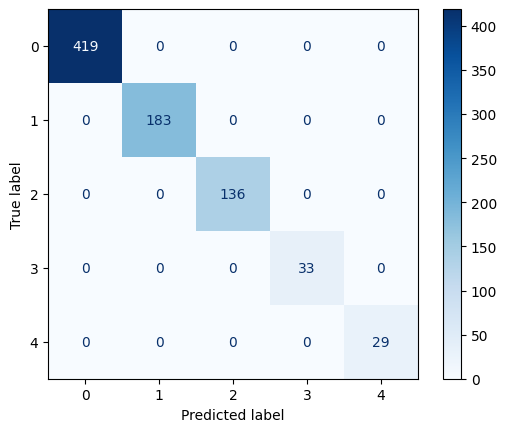

In [18]:
y_true = training_df['Disease category'] - 1

y_pred = []
training_id = training_df['ID'].tolist()
for id in training_id:
    mfccs_feature = audio_to_mfccs(training_df[training_df['ID']==id]['wav_path'].values[0])
    mfccs_df = pd.DataFrame(mfccs_feature)
    df = mfccs_df.copy()

    # 取病理資料接續在mfcc特徵後面
    medical_data = training_data_medical[training_data_medical['ID']==id].iloc[:, 1:]
    for col_name in medical_data.columns:
        df[col_name] = medical_data[col_name].values[0]

    # 透過聲學模型預測此病人 (By frame)
    frame_pred = acoustic_model.predict(mfccs_df)
    frame_pred_df = pd.DataFrame(frame_pred)
    df = pd.concat([df, frame_pred_df], axis=1)  # 將聲學模型預測結果接在每個frame的特徵後面

    # 透過病理模型預測此病人
    medical_pred = medical_model.predict(medical_data)
    df['medical_pred_c1'] = medical_pred[0][0]
    df['medical_pred_c2'] = medical_pred[0][1]
    df['medical_pred_c3'] = medical_pred[0][2]
    df['medical_pred_c4'] = medical_pred[0][3]
    df['medical_pred_c5'] = medical_pred[0][4]

    frame_pred = model.predict(df)
    frame_pred_results = frame_pred.argmax(axis=1)
    person_pred = np.array([np.sum(frame_pred_results==0), np.sum(frame_pred_results==1), np.sum(frame_pred_results==2), np.sum(frame_pred_results==3), np.sum(frame_pred_results==4)]).argmax()  # 注意!如三類別相同票數，預測會為0

    y_pred.append(person_pred)

results_recall = recall_score(y_true, y_pred, average=None)
print("Training UAR(Unweighted Average Recall) :", results_recall.mean())

cm = confusion_matrix(y_true, y_pred)

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(cmap='Blues')

# 驗證資料測試結果

12/12 [==============================] - 0s 1ms/step


12/12 [==============================] - 0s 1ms/step
Test UAR(Unweighted Average Recall) : 0.4165474915474915


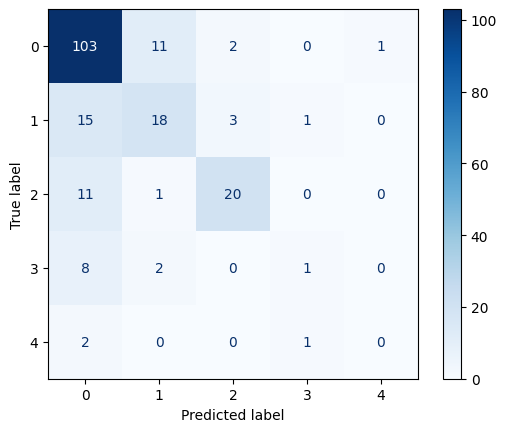

In [19]:
y_true = test_df['Disease category'] - 1

y_pred = []
training_id = test_df['ID'].tolist()
for id in training_id:
    mfccs_feature = audio_to_mfccs(test_df[test_df['ID']==id]['wav_path'].values[0])
    mfccs_df = pd.DataFrame(mfccs_feature)
    df = mfccs_df.copy()

    # 取病理資料接續在mfcc特徵後面
    medical_data = test_data_medical[test_data_medical['ID']==id].iloc[:, 1:]
    for col_name in medical_data.columns:
        df[col_name] = medical_data[col_name].values[0]

    # 透過聲學模型預測此病人 (By frame)
    frame_pred = acoustic_model.predict(mfccs_df)
    frame_pred_df = pd.DataFrame(frame_pred)
    df = pd.concat([df, frame_pred_df], axis=1)  # 將聲學模型預測結果接在每個frame的特徵後面

    # 透過病理模型預測此病人
    medical_pred = medical_model.predict(medical_data)
    df['medical_pred_c1'] = medical_pred[0][0]
    df['medical_pred_c2'] = medical_pred[0][1]
    df['medical_pred_c3'] = medical_pred[0][2]
    df['medical_pred_c4'] = medical_pred[0][3]
    df['medical_pred_c5'] = medical_pred[0][4]

    frame_pred = model.predict(df)
    frame_pred_results = frame_pred.argmax(axis=1)
    person_pred = np.array([np.sum(frame_pred_results==0), np.sum(frame_pred_results==1), np.sum(frame_pred_results==2), np.sum(frame_pred_results==3), np.sum(frame_pred_results==4)]).argmax()  # 注意!如三類別相同票數，預測會為0

    y_pred.append(person_pred)

results_recall = recall_score(y_true, y_pred, average=None)
print("Test UAR(Unweighted Average Recall) :", results_recall.mean())

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(cmap='Blues')